In [2]:
import pandas as pd
import gzip
import json
import pyarrow.ipc as ipc
import pyarrow.feather as feather

In [3]:
PATH_TO_DATA = "../data_youniverse"  
CATEGORY = "Pets & Animals"

In [4]:
# Function to load gzipped TSV data into a pandas dataframe
def load_tsv_gz_file(filepath):
    with gzip.open(filepath, 'rt') as f:
        df = pd.read_csv(f, delimiter='\t')
    return df

def load_and_filter_jsonl_gz_file_by_chunks(filepath, chunk_size=10000, exclude_fields=None):
    '''
    Spefcify the chunk size and the fiels to exclude or not if needed. 
    Return the video matedatas of video include in the global variable category
    '''
    if exclude_fields is None:
        exclude_fields = ['title', 'description']
    dataframe_chunks = []
    
    with gzip.open(filepath, 'rt', encoding='utf-8') as f:
        records = []
        for line in f:
            # Exclude unwanted fields here
            record = {k: v for k, v in json.loads(line).items() if k not in exclude_fields}
            records.append(record)
            
            if len(records) == chunk_size:
                df_chunk = pd.DataFrame(records)
                df_filtered = df_chunk[df_chunk['categories'] == CATEGORY].drop(columns=exclude_fields, errors='ignore')
                dataframe_chunks.append(df_filtered)
                records = []
        
        # Make sure to process the last chunk
        if records:
            df_chunk = pd.DataFrame(records)
            df_filtered = df_chunk[df_chunk['categories'] == CATEGORY].drop(columns=exclude_fields, errors='ignore')
            dataframe_chunks.append(df_filtered)
    
    return pd.concat(dataframe_chunks, ignore_index=True)

def read_and_filter_feather(path):
    # Open the feather file using pyarrow.ipc's RecordBatchFileReader
    reader = ipc.RecordBatchFileReader(path)

    # Initialize an empty list to store the filtered DataFrames
    filtered_dfs = []
    # Loop over all batches
    num_batches = reader.num_record_batches
    for i in range(num_batches):
        # Get the ith batch
        batch = reader.get_batch(i)
        
        # Convert the batch to a pandas DataFrame
        df = batch.to_pandas()
        
        # Filter the DataFrame by category
        filtered_df = df[df['categories'] == CATEGORY]
        
        # If the filtered DataFrame is not empty, add it to the list
        if not filtered_df.empty:
            filtered_dfs.append(filtered_df)

    # Once the loop is complete, concatenate all the filtered DataFrames
    final_df = pd.concat(filtered_dfs, ignore_index=True)
    return final_df

In [5]:
df_channels_en = pd.read_csv(f"{PATH_TO_DATA}/df_channels_en.tsv.gz", compression="infer", sep="\t") 
# df_channels_en.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [6]:
df_timeseries_en = pd.read_csv(f"{PATH_TO_DATA}/df_timeseries_en.tsv.gz", compression="infer", sep="\t") # 20s
# df_timeseries_en.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03 00:00:00,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10 00:00:00,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17 00:00:00,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24 00:00:00,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31 00:00:00,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0


In [7]:
df_channels_filt = df_channels_en[df_channels_en['category_cc'] == CATEGORY]
df_timeseries_filt = df_timeseries_en[df_timeseries_en['category'] == CATEGORY]

In [12]:
helper_filt = read_and_filter_feather(f"{PATH_TO_DATA}/yt_metadata_helper.feather")
helper_filt.head()

In [62]:
# UNCOMMENT IF NEEDED
# yt_metadata_filtered = load_and_filter_jsonl_gz_file_by_chunks(f"{PATH_TO_DATA}/yt_metadata_en.jsonl.gz") # 21m for pets and animals (should be the same for the other at it is reading all the file anyway)
# yt_metadata_filtered.to_csv(f"{PATH_TO_DATA}/yt_metadata_pets&animals.csv", index=False) # stock the results
# yt_metadata_filt.head()

# Analysis of pets & animals category and tags

In [43]:
yt_metadata_filt = pd.read_csv(f"{PATH_TO_DATA}/yt_metadata_pets&animals.csv")
# les channels id sont les vrai, ont peut retrouver les chaines youtube !

In [60]:
yt_metadata_filt['upload_date'] = pd.to_datetime(yt_metadata_filt['upload_date'])

In [45]:
yt_metadata_filt.describe()

,dislike_count,duration,like_count,view_count
count,626115.000000,645508.000000,6.261150e+05,6.455070e+05
mean,60.854899,483.984662,1.053866e+03,1.116582e+05
std,1277.645610,1931.183349,1.040833e+04,1.666015e+06
min,0.000000,1.000000,0.000000e+00,0.000000e+00
25%,0.000000,67.000000,5.000000e+00,3.610000e+02
50%,1.000000,166.000000,3.300000e+01,1.963000e+03
75%,7.000000,441.000000,2.030000e+02,1.155700e+04
max,433301.000000,86376.000000,1.521185e+06,4.142213e+08


### Plot the top 3 tags for a range of years

In [72]:
def plot_topN_tag(tag_col, N):
    # Step 1: Split the `tags` column into individual tags and explode the DataFrame.
    tags_exploded = tag_col.str.split(',').explode()

    # Step 2: Count the occurrences of each tag.
    tags_count = tags_exploded.value_counts()

    # Step 3: Sort the results and plot the top 10 tags.
    top_tags = tags_count.head(N)
    top_tags.plot(kind='bar')
    plt.title(f'Top {N} Tags')
    plt.xlabel('Tags')
    plt.ylabel('Count')
    plt.show()

years = range(2016, 2020)  # or whatever years are applicable
for year in years:
    yt_metadata_filt_year = yt_metadata_filt[yt_metadata_filt['upload_date'].dt.year == year]
    if not yt_metadata_filt_year.empty:
        try:
            # Assuming the function plot_topN_tag is correctly defined and can handle cases with less than N tags
            plot_topN_tag(yt_metadata_filt_year['tags'], 3)
        except Exception as e:
            print(f"An error occurred for year {year}: {e}")
    else:
        print(f"No data available for year {year}")

### Cleaning of NaN values (not extensive)

In [82]:
def clean_dataframe(df):
    # Remove rows where 'tags' is empty or NaN
    initial_row_count = len(df)
    df = df.dropna(subset=['tags'])  # Drops rows with NaN in 'tags'
    df = df[df['tags'].str.strip().astype(bool)]  # Drops rows with empty 'tags'
    cleaned_row_count = len(df)

    # Check for NaN values in 'like_count'
    like_count_nan = df['like_count'].isna().sum()
    if like_count_nan > 0:
        # Handle NaN values here. Options: fill with 0, mean, median, etc.
        # Example: df['like_count'].fillna(df['like_count'].median(), inplace=True)
        # For now, we'll just drop these rows
        df = df.dropna(subset=['like_count'])

    # Print out the cleaning summary
    print(f"Rows with empty 'tags' removed: {initial_row_count - cleaned_row_count}")
    print(f"Rows with NaN in 'like_count': {like_count_nan}")

    return df

# Clean the yt_metadata_filtered dataframe
yt_metadata_filt_clean = clean_dataframe(yt_metadata_filt)

Rows with empty 'tags' removed: 76450
Rows with NaN in 'like_count': 18257


### Plot evolution of most popular tags

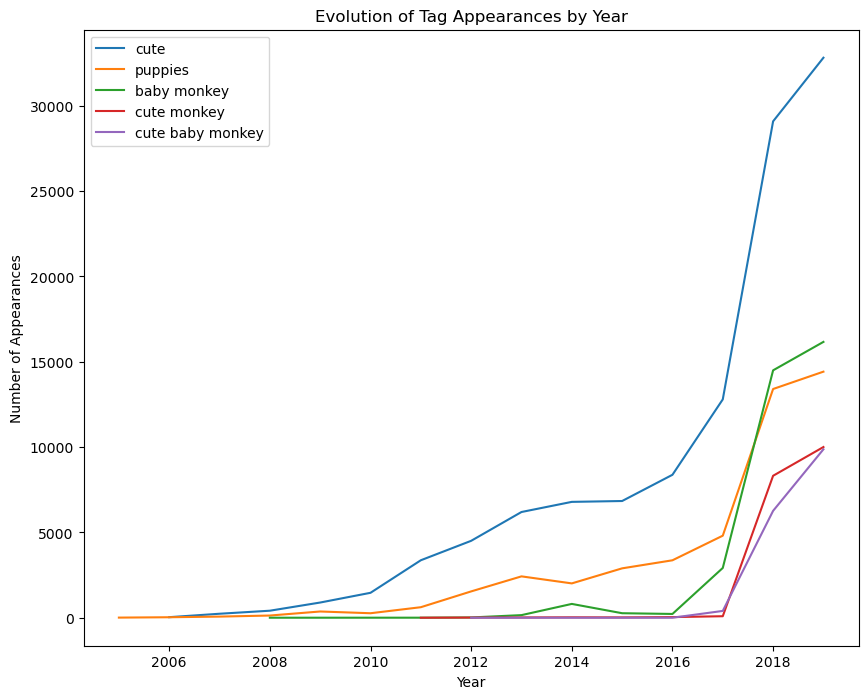

In [84]:
def get_top_tags_for_year(df, year, top_n=5):
    """ Get the top N tags for a given year from the dataframe """
    year_data = df[df['upload_date'].dt.year == year]
    tag_list = year_data['tags'].str.split(',').explode()
    top_tags = tag_list.value_counts().head(top_n).index
    return top_tags

def count_tag_appearances_by_year(df, tags):
    """ Count the number of appearances of each tag by year """
    df['year'] = df['upload_date'].dt.year
    tag_counts_by_year = {tag: df[df['tags'].str.contains(tag)]['year'].value_counts().sort_index() for tag in tags}
    return tag_counts_by_year

def plot_tag_counts(tag_counts_by_year):
    """ Plot the evolution of tag counts over the years """
    plt.figure(figsize=(10, 8))
    for tag, counts in tag_counts_by_year.items():
        plt.plot(counts.index, counts.values, label=tag)
    
    plt.xlabel('Year')
    plt.ylabel('Number of Appearances')
    plt.title('Evolution of Tag Appearances by Year')
    plt.legend()
    plt.show()

top_tags_2019 = get_top_tags_for_year(yt_metadata_filt_clean, 2019)
tag_counts_by_year = count_tag_appearances_by_year(yt_metadata_filt_clean, top_tags_2019)
plot_tag_counts(tag_counts_by_year)

### Dataframe of statistics grouped by year

In [68]:
# Convert `upload_date` to DateTime and extract the year.
yt_metadata_filt['upload_year'] = pd.to_datetime(yt_metadata_filt['upload_date']).dt.year

# Group by the extracted year.
grouped = yt_metadata_filt.groupby('upload_year')

# Initialize a dictionary to hold aggregated data.
aggregated_data = {}

# Iterate over each group to perform aggregations.
for name, group in grouped:
    # Get the most popular tag for each year.
    popular_tag = group['tags'].str.split(',').explode().value_counts().idxmax()
    
    # Get other statistics for each year.
    aggregated_data[name] = {
        'most_popular_tag': popular_tag,
        'total_like_count': group['like_count'].sum(),
        'total_videos': group['upload_date'].count(),
        'total_duration': group['duration'].sum(),
        'unique_channels': group['channel_id'].nunique(),
        'total_dislike_count': group['dislike_count'].sum(),
        'total_view_count': group['view_count'].sum(),
        'mean_dislike_count': group['dislike_count'].mean(),
        'mean_like_count': group['like_count'].mean(),
        'mean_duration': group['duration'].mean(),
    }

# Convert aggregated data to a DataFrame.
stats_df = pd.DataFrame.from_dict(aggregated_data, orient='index')

# Display the DataFrame
stats_df.head(20)

,most_popular_tag,total_like_count,total_videos,total_duration,unique_channels,total_dislike_count,total_view_count,mean_dislike_count,mean_like_count,mean_duration
2005,stockshot,1591.0,55,2234,3,244.0,1.209850e+06,4.436364,28.927273,40.618182
2006,wildlife,167536.0,603,63328,121,16306.0,8.822035e+07,27.267559,280.160535,105.021559
2007,wildlife,1733870.0,4173,882767,377,263668.0,1.064966e+09,64.719686,425.594011,211.542535
2008,wildlife,2303453.0,6921,1314017,624,210694.0,8.895033e+08,31.140112,340.445315,189.859413
2009,cat,4688954.0,10295,1828428,938,362601.0,1.392648e+09,36.782410,475.649625,177.603497
2010,cat,7248150.0,15596,2700539,1328,477808.0,1.591495e+09,31.921967,484.243052,173.155873
2011,cute,9048792.0,21037,3777001,1884,606958.0,1.899059e+09,29.638068,441.857122,179.540857
2012,cute,12320157.0,30398,6208834,2348,851454.0,2.546439e+09,28.626076,414.206462,204.251398
2013,cute,24071570.0,38922,8284192,2225,1899234.0,4.463004e+09,49.596125,628.598997,212.840861
2014,cute,30244055.0,37009,9029726,1887,2191575.0,6.030014e+09,60.244516,831.383116,243.987300


### Plot evolution of metrics of previous dataframe

In [51]:
def plot_stats_over_years(df, columns):
    """
    Plots the evolution of specified columns from a DataFrame over the years.
    
    Parameters:
    - df: pandas DataFrame with a year index and columns to plot.
    - columns: list of strings representing the column names to plot.
    """
    if not isinstance(columns, list):
        columns = [columns]  # Convert to list if a single column name is passed.
        
    for column in columns:
        if column in df.columns:
            plt.plot(df.index, df[column], label=column)
        else:
            print(f"Column '{column}' not found in the DataFrame.")
    
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.title('Evolution of Statistics Over Years')
    plt.legend()
    plt.show()

plot_stats_over_years(stats_df, ['total_like_count', 'total_dislike_count'])
plot_stats_over_years(stats_df, ['mean_dislike_count', 'mean_like_count', 'mean_duration'])

### Reproduce plot of the paper for specific category

In [22]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import os
# fontpath = os.path.expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
# prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    # 'font.family': prop.get_name(),
    'text.usetex': True
}

# mpl.rcParams.update(params)

# import sys
# # Local Modules
# sys.path.insert(0, os.path.abspath('/scratch/horta/youtube_dataset/'))
# from helpers.plot import set_size

import warnings
warnings.filterwarnings('ignore')

In [23]:
df_sb_f = df_timeseries_filt
df_vd_f = helper_filt
df_ch_f = df_channels_filt
df_vd_f["dummmy"] = 1

In [24]:
# gets videos_yt count
df_vd_vid_count = dict(df_vd_f.groupby("channel_id").count().display_id) 
df_ch_f["videos_yt"] = df_ch_f["channel"].apply(lambda x: df_vd_vid_count.get(x, 0))

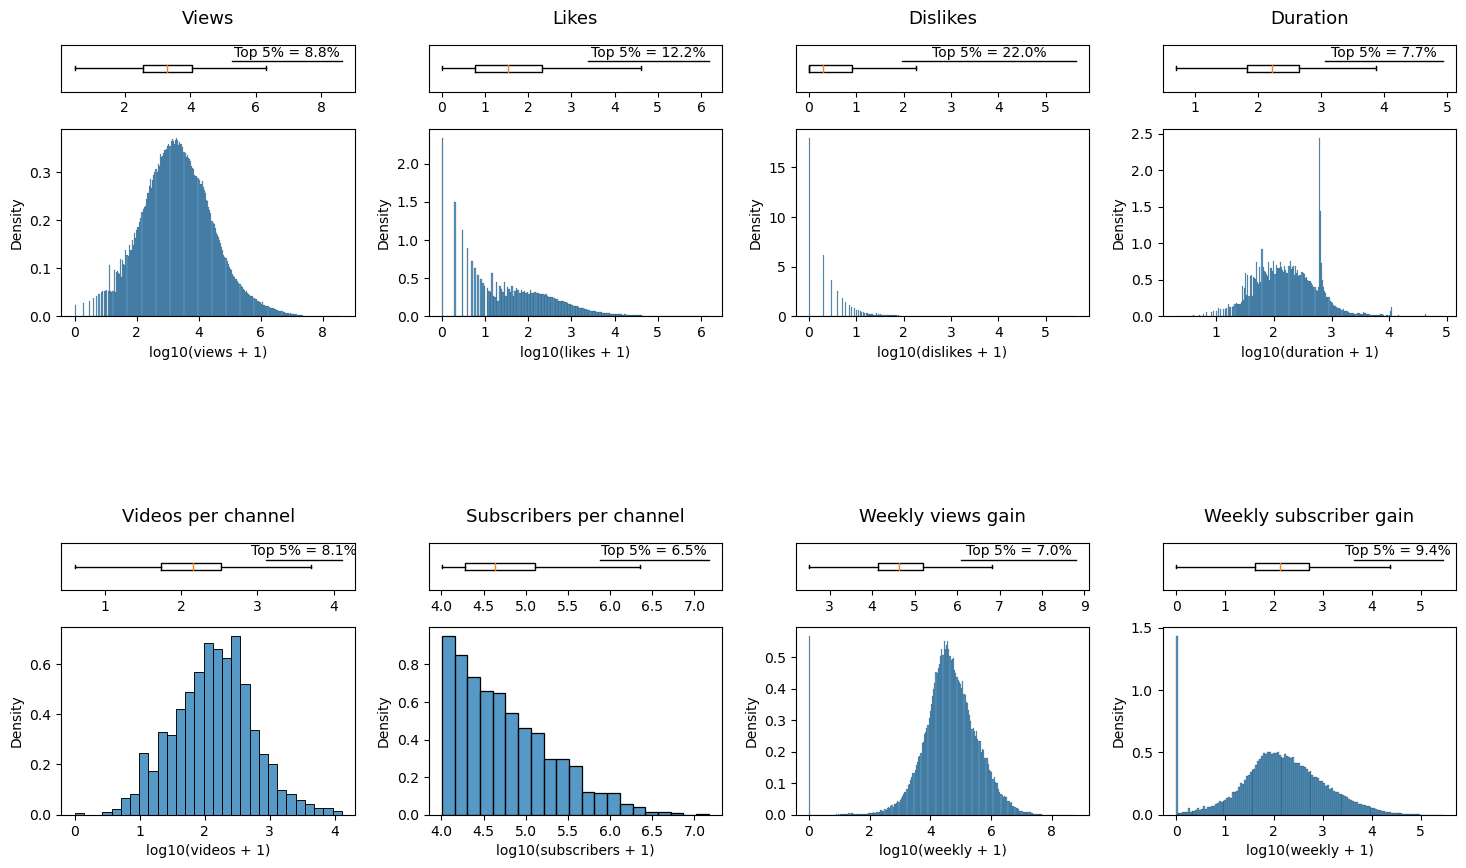

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df_vd_f, df_ch_f, df_sb_f are predefined dataframes
# Setup the figure and axes
fig, axs = plt.subplots(5, 4, figsize=(18, 10),  # Adjust figure size here
                        gridspec_kw={"wspace": 0.25, "hspace": 0.3,
                                     "height_ratios": [0.2, 0.8, 0.65, 0.2, 0.8]})

# Function to plot mean
def plot_mean(ax, vals):
    quant95 = vals.quantile(0.95)
    quant100 = vals.quantile(1)
    top5p = vals[vals >= quant95].sum() / sum(vals)
    ax.plot([quant95, quant100], [1.15, 1.15], lw=1, color="black")
    ax.text((quant95 + quant100) / 2, 1.25, f"Top 5% = {round(top5p*100,1)}%", ha="center", size=10)

# Function to plot box
def plot_box(ax, vals):
    ax.boxplot(vals, showfliers=False, vert=False)
    ax.set_yticks([])

# Loop through the video stats
video_titles = ["Views", "Likes", "Dislikes", "Duration"]
video_cols = ["view_count", "like_count", "dislike_count", "duration"]

for idx, title in enumerate(video_titles):
    ax = axs[1, idx]
    sns.histplot(np.log10(df_vd_f[video_cols[idx]] + 1), kde=False, ax=ax, stat="density")
    ax.set_xlabel(f'log10({title.lower()} + 1)')
    
    ax = axs[0, idx]
    ax.set_title(title, pad=15, size=13)  # Adjust title size here
    vals = np.log10(df_vd_f[video_cols[idx]].dropna() + 1)
    plot_box(ax, vals)
    plot_mean(ax, vals)

# Loop through the channel stats
channel_titles = ["Videos per channel", "Subscribers per channel"]
channel_cols = ["videos_yt", "subscribers_cc"]

for idx, title in enumerate(channel_titles):
    ax = axs[4, idx]
    sns.histplot(np.log10(df_ch_f[channel_cols[idx]] + 1), kde=False, ax=ax, stat="density")
    ax.set_xlabel(f'log10({title.lower().split()[0]} + 1)')
    
    ax = axs[3, idx]
    ax.set_title(title, pad=15, size=13)  # Adjust title size here
    vals = np.log10(df_ch_f[channel_cols[idx]].dropna() + 1)
    plot_box(ax, vals)
    plot_mean(ax, vals)

# Loop through the time series stats
time_series_titles = ["Weekly views gain", "Weekly subscriber gain"]
time_series_cols = ["delta_views", "delta_subs"]

for idx, title in enumerate(time_series_titles):
    ax = axs[4, idx+2]
    sns.histplot(np.log10(df_sb_f[time_series_cols[idx]] + 1), kde=False, ax=ax, stat="density")
    ax.set_xlabel(f'log10({title.lower().split()[0]} + 1)')
    
    ax = axs[3, idx+2]
    ax.set_title(title, pad=15, size=13)  # Adjust title size here
    vals = np.log10(df_sb_f[time_series_cols[idx]].dropna() + 1)
    plot_box(ax, vals)
    plot_mean(ax, vals)

# Hide the unnecessary subplots
for ax in axs[2, :]:
    ax.set_visible(False)

# Remove the last plot in the first two rows
# for ax in axs[0:2, -1]:
#     ax.remove()
    
# Adjust the tick marks and limits for specific subplots if needed
# If the last column was removed, this loop is not needed
# for ax in axs[:, -1]:
#     ax.set_xticks([0, 2, 4, 6])
#     ax.set_xlim([0, 7])

plt.tight_layout()
plt.show()
